# RAPsounding_SCMdeltas_PickleDeltas script

I have decided to run the program at a 1.75-hour interval, starting 30 min before the top of the hour when the sounding is gathered (i.e., a 1.9-hour window with 30-min before and 20-min after the hour of interest). Running the program for 1-hour blocks of interest should work, although the storm of interest may be given a different ID each time.

## Annoyingly excessive list of imports. Sorry.

In [1]:
import os.path
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dewpoint_from_relative_humidity, dry_lapse, moist_lapse, vapor_pressure, 
                        saturation_vapor_pressure, wind_speed, wind_direction, pressure_to_height_std, mixing_ratio, cape_cin, 
                        wind_components, height_to_pressure_std, equivalent_potential_temperature, parcel_profile, 
                        precipitable_water, storm_relative_helicity, mean_pressure_weighted, most_unstable_cape_cin, 
                        most_unstable_parcel, supercell_composite, significant_tornado, get_layer, 
                        relative_humidity_from_dewpoint)
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.calc import wind_direction
from metpy.units import units
from metpy.calc import lcl
from metpy.interpolate import interpolate_1d as metinterp
from metpy.interpolate import log_interpolate_1d
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from metpy.plots import SkewT
from metpy.plots import Hodograph
import metpy.calc as metcalc

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv
from stormdelta_framework_streamlined_noDP import storm_motion_deltas_algorithm
from stormdelta_local_noDP import storm_motion_deltas_local
import pandas as pd
import math
import glob
import shutil
import re
import time


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



x:\anaconda\envs\scmdeltas\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
x:\anaconda\envs\scmdeltas\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X

## Must set the two variables below for the hour(s) of radar and sounding data. The Inputdata.csv file must exist for this script to function.

In [2]:
duration = 1.9    # number of hours of radar data to use (still fiddling with this)
############

# start minutes of radar analysis (adjust based on duration); minS = 45 starts 15 min before the top of the hour
minS = 25

# maximum distance (e.g., 10 km) that a new storm object falls from the position of an old storm object
# Not as important now that the storm track is being projected. At most, only increase to 12 to 15 km. 
searchkm = 10

# number of seconds in the past (e.g., 600 sec = 10 min) that is used to calculate storm motion
numsecs = 1200  #20 min
#numsecs = 1800  #30 min

# exact row that you want to analyze from Inputdata.csv file (0 = first row of data after header)
i = 1
## don't use 5,10,29,35,39,97,101-104 (last = 125)

# set to 0 to not run or 1 to run (0 to just recreate the scatter plots)
runSCM = 1

# set to 1 to override radar download even if radar data already exist
forceRADAR = 1

# shear layer over which to compute the storm motion deltas (only 6, 3, & 1 km are options, at present)
offhodoshear = 6


x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Read relevant inputs from a comma-delimited csv file with header row.  Use UTC time.

In [3]:
#Inputdata = np.genfromtxt("Inputdata.csv", delimiter = ",", skip_header = 1, dtype=str)
Inputdata = np.genfromtxt("VDB2020_cases.csv", delimiter = ",", skip_header = 1, dtype=str)
site = Inputdata[i,1]
print()

#Inputdata = np.genfromtxt("Inputdata.csv",delimiter = ",", skip_header = 1)
Inputdata = np.genfromtxt("VDB2020_cases.csv",delimiter = ",", skip_header = 1)
yearR = Inputdata[i,2].astype(int)          # UTC start hour of the radar data
monthR = Inputdata[i,3].astype(int)
dayR = Inputdata[i,4].astype(int)
hourR = Inputdata[i,5].astype(int)

year = Inputdata[i,6].astype(int)         # UTC start hour of the sounding data
month = Inputdata[i,7].astype(int)
day = Inputdata[i,8].astype(int)
hour = Inputdata[i,9].astype(int)

cenlat = Inputdata[i,10].astype(float)      # latitude of inflow sounding during hour of interest
cenlon = Inputdata[i,11].astype(float)      # longitude of inflow sounding during hour of interest
dayC = Inputdata[i,12].astype(int)          # primary CST day of tornado reports for storm
stormID = Inputdata[i,13].astype(int)       # primary stormID during the time of interest (a posteriori)
stormID2 = Inputdata[i,14].astype(int)      # secondary stormID2 during the time of interest (a posteriori)
stormNum = Inputdata[i,15].astype(int)      # Storm # for a given multi-storm event

if i == 36 and numsecs == 1800:
    stormID2 = 19
if i == 52 and numsecs == 1800:
    stormID = 24
if i == 84 and numsecs == 1800:
    stormID2 = 53
if i == 88 and numsecs == 1800:
    stormID = 18
if i == 112 and numsecs == 1800:
    stormID = 26
    stormID2 = 53

#localradar = "C:/Users/mbunkers/Matthew/Python/Storm_Motion_Deltas/RadarFolder/"+str(site)+'-'+str(yearR)+"-"+str(monthR)+"-"+str(dayR)
#localradar = 'RadarFolder/'+str(site)+'-'+str(yearR)+"-"+str(monthR)+'-'+str(dayR)+'-'+str(hourR)
localradar = 'E:/Level2/Storm_Motion_Deltas/RadarFolder/'+str(site)+'-'+str(yearR)+"-"+str(monthR)+'-'+str(dayR)+'-'+str(hourR)

print("RUC/RAP sounding lat/lon =", cenlat, "&", cenlon)
print()
print(site, ":", year, month, day, "; sounding start hour =", hour, "UTC")
print()
print(site, ":", yearR, monthR, dayR, "; radar start hour/min =", hourR, ":", minS, "UTC")
print()
print("stormID =", stormID, "; stormID2 =", stormID2, "; stormNum =", stormNum)
print()

try:
    print(os.listdir(localradar))
    print()
except:
    print("Cannot find localradar data.")
    print()

isDir = os.path.isdir(localradar)  
print(isDir)
print()

newpath = r'RadarFolder/'+str(site)+'-'+str(yearR)+"-"+str(monthR)+'-'+str(dayR)+'-'+str(hourR)

MLpath = r'Machine_Learning/'+str(site)+'-'+str(yearR)+"-"+str(monthR)+'-'+str(dayR)+'-'+str(hourR)
MLfiles = 'Machine_Learning/DELTA_dev'+str(site)+str(yearR)+'-'+str(monthR)+'*.png'

scatterpath = r'Scatterplots/'+str(site)+'-'+str(yearR)+"-"+str(monthR)+'-'+str(dayR)
if month < 10:
    scatterfiles = 'Scatterplots/scatter'+str(site)+str(stormNum)+'-'+str(year)+'0'+str(month)+'*.png'
else:
    scatterfiles = 'Scatterplots/scatter'+str(site)+str(stormNum)+'-'+str(year)+str(month)+'*.png'

#if os.path.exists(MLpath):
    #for f in os.listdir(MLpath):
        #pattern = 'DELTA_dev'+str(site)+str(yearR)+str(monthR)    
        #if re.search(pattern, f) and runSCM == 1:
            #print(pattern)
            #os.remove(os.path.join(MLpath, f))


RUC/RAP sounding lat/lon = 35.4915 & -86.5816

KOHX : 2012 4 26 ; sounding start hour = 23 UTC

KOHX : 2012 4 26 ; radar start hour/min = 22 : 25 UTC

stormID = 16 ; stormID2 = 17 ; stormNum = 1

Cannot find localradar data.

False



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Specify the reflectivity thresholds for the storm tracking algorithm

In [4]:
REFlevsA = Inputdata[i,17].astype(int)
REFlev1sA = Inputdata[i,18].astype(int)
bigstorms = Inputdata[i,19].astype(int)

REFlevs = np.asarray([REFlevsA, 999])
REFlev1s = np.asarray([REFlev1sA, 999])

big_storms = np.asarray([bigstorms, 100000])

print(REFlevs)
print(REFlev1s)
print(big_storms)
print()

[ 35 999]
[ 42 999]
[   300 100000]



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Combine the above inputs into a time

In [5]:
time_start = datetime(year, month, day, hour, 0) # Our specified time
print()
print(time_start)
print()
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)


2012-04-26 23:00:00



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## This block grabs the RUC/RAP sounding output from the NOMADS thredds server. Some options might not work. For troubleshooting the thredds link, I usually go to  https://www.ncei.noaa.gov/thredds/model/model.html and click through to an individual day's RAP archive file to see what's changed in the url.

In [6]:
##  https://www.ncei.noaa.gov/thredds/model/rucrap.html

cat = None

try:
    with open('RUCRAP/sounding'+str(site)+'_'+str(month)+'_'+str(day)+'_'+str(year)+'_'+str(hour)+'z_'+str(cenlat)+'_'+str(cenlon)+'.pkl', 'rb') as fsnd:
        sounding_array2 = pickle.load(fsnd)
        file = 1
        fileS = 1
        print()
        print("We already have an archived PKL sounding file. Yay!")
        print()
except:
    file = 0
    fileS = 0


## 1    
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1!")
    except:
        file = 0
        print("No file yet...")

## 2
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2!")
    except:
        file = 0
        print("No file yet...")
        
## 3
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3!")
    except:
        file = 0
        print("No file yet...")

## 4
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4!")
    except:
        file = 0
        print("No file yet...")        
        
## 1b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1b!")
    except:
        file = 0
        print("No file yet...")

## 2b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2b!")
    except:
        file = 0
        print("No file yet...")
        
## 3b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3b!")
    except:
        file = 0
        print("No file yet...")

## 4b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4b!")
    except:
        file = 0
        print("No file yet...")


## 5
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")
        
## 6
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap130anal!")
#    except:
#        file = 0
#        print("No file yet...rap130anal")

## 7
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap252anal!")
#    except:
#        file = 0
#        print("No file yet...rap252anal")

## 8
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")


## 9
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/catalog.html?dataset=rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/rap_130_'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'_'+str(time_start.hour)+'00_001.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 10
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 11
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 12
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 13
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")

## 14
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 15
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("We didn't get any file!")


## 1st choice (13-km RAP)
#cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/catalog.html?dataset=rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/rap_130_'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'_'+str(time_start.hour)+'00_001.grb2')
#cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
## 2nd choice (20-km RAP)
#cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
## Option for the 13-km RUC analysis dataset
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
## Option for the 20-km RUC analysis dataset
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')


if fileS == 0:
    try:
        latest_ds = list(cat.datasets.values())[0]
        print()
        print(latest_ds.access_urls)
        print("here1")
        ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])
        print(ncss)
        print("here2")

        query = ncss.query()
        query.variables('Vertical_velocity_pressure_isobaric').variables('Convective_available_potential_energy_surface').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Storm_relative_helicity_height_above_ground_layer').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Vertical_u-component_shear_height_above_ground_layer').variables('Vertical_v-component_shear_height_above_ground_layer').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric').variables('MSLP_MAPS_System_Reduction_msl')
        query.add_lonlat().lonlat_box(cenlon-2.1, cenlon +2.1, cenlat-2.1, cenlat+2.1)
        data1 = ncss.get_data(query)
        dtime = data1.variables['Geopotential_height_isobaric'].dimensions[0]
        dlev = data1.variables['Geopotential_height_isobaric'].dimensions[1]
        dlat = data1.variables['Geopotential_height_isobaric'].dimensions[2]
        dlon = data1.variables['Geopotential_height_isobaric'].dimensions[3]
        CAPE = np.asarray(data1.variables['Convective_available_potential_energy_surface'][:]) * units('J/kg')
        SRH = np.asarray(data1.variables['Storm_relative_helicity_height_above_ground_layer'][:]) * units('m/s')
        SFCP = (np.asarray(data1.variables['Pressure_surface'][:])/100.) * units('hPa')
        Td = (np.asarray(data1.variables['Dewpoint_temperature_height_above_ground'][:]) * units('kelvin')).to('degC')
        T = np.asarray(data1.variables['Temperature_height_above_ground'][:]) * units('kelvin')
        #ushr = data1.variables['Vertical_u-component_shear_height_above_ground_layer'][:] * units('m/s')
        #vshr = data1.variables['Vertical_v-component_shear_height_above_ground_layer'][:] * units('m/s')
        hgt = np.asarray(data1.variables['Geopotential_height_isobaric'][:]) * units('meter')
        sfc_hgt = np.asarray(data1.variables['Geopotential_height_surface'][:]) * units('meter')
        uwnd = np.asarray(data1.variables['u-component_of_wind_isobaric'][:]) * units('m/s')
        vwnd = np.asarray(data1.variables['v-component_of_wind_isobaric'][:]) * units('m/s')
        Temp_up = np.asarray(data1.variables['Temperature_isobaric'][:]) * units('kelvin')
        VVEL_up = np.asarray(data1.variables['Vertical_velocity_pressure_isobaric'][:]) * units('Pa/s')
        RH_up = np.asarray(data1.variables['Relative_humidity_isobaric'][:])
        usfc = np.asarray(data1.variables['u-component_of_wind_height_above_ground'][:]) * units('m/s')
        vsfc = np.asarray(data1.variables['v-component_of_wind_height_above_ground'][:]) * units('m/s')
        MSLP = (np.asarray(data1.variables['MSLP_MAPS_System_Reduction_msl'][:])/100.) * units('hPa')

        ## Get the dimension data
        lats_r = data1.variables[dlat][:]
        lons_r= data1.variables[dlon][:]
        lev = (np.asarray(data1.variables[dlev][:])/100.) * units('hPa')

        flon = float(cenlon)
        flat = float(cenlat)

        ## Set up our array of latitude and longitude values and transform to 
        ## the desired projection.
        crs = ccrs.PlateCarree()
        crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
        trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),crlons,crlats)
        trlons = trlatlons[:,:,0]
        trlats = trlatlons[:,:,1]
        dlon = np.abs(trlons - cenlon)
        dlat = np.abs(trlats - cenlat)
        ilon = np.where(dlon == np.min(dlon))
        ilat = np.where(dlat == np.min(dlat))
        print()
    except:
        print()
        print("There is no RUC or RAP sounding availble. Try again later.")
        print()
else:
    print()


We already have an archived PKL sounding file. Yay!




x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Assemble everything into a sounding

In [7]:
if fileS == 0:
    try:
        RH_prof = RH_up[0,:,ilat[0][0], ilon[1][0]]
        Tdc_up = dewpoint_from_relative_humidity(Temp_up[0,:,ilat[0][0], ilon[1][0]],RH_up[0,:,ilat[0][0], ilon[1][0]]/100)
        Omega = VVEL_up[0,:,ilat[0][0], ilon[1][0]]

        p_sounding = np.sort(np.append(lev, SFCP[0,ilat[0][0], ilon[1][0]]))
        ind = np.where(p_sounding >= SFCP[0,ilat[0][0], ilon[1][0]])[0][0]
        hgt_sounding = np.insert(hgt[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, sfc_hgt[0,ilat[0][0], ilon[1][0]].magnitude) * hgt.units
        T_sounding = (np.insert(Temp_up[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, T[0,0,ilat[0][0], ilon[1][0]].magnitude) * T.units).to(Tdc_up.units)
        Td_sounding = np.insert(Tdc_up.magnitude, ind, Td[0,0,ilat[0][0], ilon[1][0]].magnitude) * Tdc_up.units
        u_sounding = np.insert(uwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, usfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units
        v_sounding = np.insert(vwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, vsfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units

        p_skewt = p_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
        hgt_skewt = hgt_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
        T_skewt = T_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
        Td_skewt = Td_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
        u_skewt = u_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]].to('kt')
        v_skewt = v_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]].to('kt')
        storm_motion = bunkers_storm_motion(p_skewt[::-1], u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1])

        ## Get RH for whole sounding
        RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)
        print()
        #Save the whole sounding to a pickle file
        #Save pressure, height, temperature, dewpoint, u, and v
        sounding_array = np.zeros((6, len(p_skewt)))
        sounding_array[0,:]=p_skewt
        sounding_array[1,:]=hgt_skewt
        sounding_array[2,:]=T_skewt
        sounding_array[3,:]=Td_skewt
        sounding_array[4,:]=u_skewt
        sounding_array[5,:]=v_skewt
        #Save to pickle
        with open('RUCRAP/sounding'+str(site)+'_'+str(month)+'_'+str(day)+'_'+str(year)+'_'+str(hour)+'z_'+str(cenlat)+'_'+str(cenlon)+'.pkl', 'wb') as f:
            pickle.dump(sounding_array, f)            
    except:
        print()
        print("There is no RUC or RAP sounding availble. Try again later.")
        print()
else:
    p_skewt=sounding_array2[0,:] * units.hPa
    hgt_skewt=sounding_array2[1,:] * units.m    
    T_skewt=sounding_array2[2,:] * units.degC
    Td_skewt=sounding_array2[3,:] * units.degC
    u_skewt=sounding_array2[4,:] * units.kt
    v_skewt=sounding_array2[5,:] * units.kt
    storm_motion = bunkers_storm_motion(p_skewt[::-1], u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1])
    RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)
    print()
    print("All six sounding variables have been loaded from PKL, with two derived variables computed. Yay!")
    print()


All six sounding variables have been loaded from PKL, with two derived variables computed. Yay!



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Put wind data into the correct format for sharppy

In [8]:
#wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)

try:
    wind_dir = []
    for i in range(len(u_skewt)):
        wdir = wind_direction(u_skewt[i], v_skewt[i])
        wind_dir.append(wdir.magnitude)
    wind_dir = np.asarray(wind_dir)
    wind_spd = wind_speed(u_skewt, v_skewt)
except:
    print()
    print("There is no RUC or RAP sounding availble. Try again later.")
    print() 

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create a sharppy profile

In [9]:
try:
    prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
except:
    print()
    print("There is no RUC or RAP sounding availble. Try again later.")
    print() 

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## This block prints out the expected Bunkers storm motion from the RUC/RAP sounding. Use SHARPpy to calculate Bunkers storm motion from the model sounding input (2014 version). [MetPy uses B2K, but incorrectly uses the pressure-weighted mean wind.] B2K is calculated in the block after this one. Ultimately, the right-moving u- and v-components are input to the Storm Motion Deltas algorithm further below.

In [10]:
## Storm motion using Bunkers et al. (2014) algorithm from SHARPpy; [0] and [1] are for RM; [2] and [3] are for LM
try:
    srwind = params.bunkers_storm_motion(prof)

    print()
    print("Bunkers Storm Motion (right-mover) [deg,kts]:", "{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[1]), 'kt / ', "{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[0]), 'deg')
    print("Bunkers Storm Motion (right-mover) [deg,m/s]:", "{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[1]*units('kt').to('m/s').magnitude), 'm/s / ', "{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[0]), 'deg')
    print()

    ## Assing u- and v-components to variables for later on
    RMspd = "{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[1]*units('kt').to('m/s').magnitude)
    RMdir = "{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[0])

    #L = ["{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[0]), ", ", "{:.2f}".format(utils.comp2vec(srwind[0], srwind[1])[1]*units('kt').to('m/s').magnitude)]
    #file1 = open("SCM.txt","w")
    #file1.writelines(L)
    #file1.close()
except:
    RMspd = 0.0
    RMdir = 270.0    
    print()
    print("There is no RUC or RAP sounding availble. Try again later.")
    print() 

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
x:\anaconda\envs\scmdeltas\lib\site-packages\numpy\lib\function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)



Bunkers Storm Motion (right-mover) [deg,kts]: 23.04 kt /  309.65 deg
Bunkers Storm Motion (right-mover) [deg,m/s]: 11.85 m/s /  309.65 deg



## Get the mean wind, RMu and RMv components using B2K, and bulk shear info for the storm deltas algorithm.

In [11]:
try:
    sfc = prof.pres[prof.sfc]
    #p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    #p500 = interp.pres(prof, interp.to_msl(prof, 500.))
    #p5500 = interp.pres(prof, interp.to_msl(prof, 5500.))

    #mean_6km = winds.mean_wind_npw(prof, pbot=sfc, ptop=p6km)
    #mag_6km = utils.mag(mean_6km[0], mean_6km[1])
    #dir_6km = wind_direction(mean_6km[0]*units('m/s'), mean_6km[1]*units('m/s'))

    #mean500 = winds.mean_wind_npw(prof, pbot=sfc, ptop=p500)
    #mean5500 = winds.mean_wind_npw(prof, pbot=p5500, ptop=p6km)

    #shear_u = mean5500[0] - mean500[0]
    #shear_v = mean5500[1] - mean500[1]

    #shear_direc = wind_direction(shear_u*units('m/s'), shear_v*units('m/s'))

    #######################

    p500 = interp.pres(prof, 500)
    p1000 = interp.pres(prof, 1000)
    p1500 = interp.pres(prof, 1500.)
    p2000 = interp.pres(prof, 2000.)
    p2500 = interp.pres(prof, 2500.)
    p3000 = interp.pres(prof, 3000.)
    p3500 = interp.pres(prof, 3500.)
    p4000 = interp.pres(prof, 4000.)
    p4500 = interp.pres(prof, 4500.)
    p5000 = interp.pres(prof, 5000.)
    p5500 = interp.pres(prof, 5500.)
    p6000 = interp.pres(prof, 6000.)
    p6500 = interp.pres(prof, 6500.)
    p7000 = interp.pres(prof, 7000.)
    p7500 = interp.pres(prof, 7500.)
    p8000 = interp.pres(prof, 8000.)
    p8500 = interp.pres(prof, 8500.)
    p9000 = interp.pres(prof, 9000.)
    p9500 = interp.pres(prof, 9500.)
    p10000 = interp.pres(prof, 10000.)
    
    print(sfc, p500, p1000)

    mean_sfc = winds.mean_wind_npw(prof, pbot=sfc, ptop=sfc)
    mean_500 = winds.mean_wind_npw(prof, pbot=p500, ptop=p500)
    mean_1000 = winds.mean_wind_npw(prof, pbot=p1000, ptop=p1000)
    mean_1500 = winds.mean_wind_npw(prof, pbot=p1500, ptop=p1500)
    mean_2000 = winds.mean_wind_npw(prof, pbot=p2000, ptop=p2000)
    mean_2500 = winds.mean_wind_npw(prof, pbot=p2500, ptop=p2500)
    mean_3000 = winds.mean_wind_npw(prof, pbot=p3000, ptop=p3000)
    mean_3500 = winds.mean_wind_npw(prof, pbot=p3500, ptop=p3500)
    mean_4000 = winds.mean_wind_npw(prof, pbot=p4000, ptop=p4000)
    mean_4500 = winds.mean_wind_npw(prof, pbot=p4500, ptop=p4500)
    mean_5000 = winds.mean_wind_npw(prof, pbot=p5000, ptop=p5000)
    mean_5500 = winds.mean_wind_npw(prof, pbot=p5500, ptop=p5500)
    mean_6000 = winds.mean_wind_npw(prof, pbot=p6000, ptop=p6000)
    mean_6500 = winds.mean_wind_npw(prof, pbot=p6500, ptop=p6500)
    mean_7000 = winds.mean_wind_npw(prof, pbot=p7000, ptop=p7000)
    mean_7500 = winds.mean_wind_npw(prof, pbot=p7500, ptop=p7500)
    mean_8000 = winds.mean_wind_npw(prof, pbot=p8000, ptop=p8000)
    mean_8500 = winds.mean_wind_npw(prof, pbot=p8500, ptop=p8500)
    mean_9000 = winds.mean_wind_npw(prof, pbot=p9000, ptop=p9000)
    mean_9500 = winds.mean_wind_npw(prof, pbot=p9500, ptop=p9500)
    mean_10000 = winds.mean_wind_npw(prof, pbot=p10000, ptop=p10000)

    mean_06u = ((mean_sfc[0]+mean_500[0]+mean_1000[0]+mean_1500[0]+mean_2000[0]+mean_2500[0]+mean_3000[0]+mean_3500[0]+mean_4000[0]+mean_4500[0]+mean_5000[0]+mean_5500[0]+mean_6000[0])/13.0)
    mean_06v = ((mean_sfc[1]+mean_500[1]+mean_1000[1]+mean_1500[1]+mean_2000[1]+mean_2500[1]+mean_3000[1]+mean_3500[1]+mean_4000[1]+mean_4500[1]+mean_5000[1]+mean_5500[1]+mean_6000[1])/13.0)
    
    mean_06u_pwgt = ((mean_sfc[0]*1.52+mean_500[0]*1.43+mean_1000[0]*1.34+mean_1500[0]*1.25+mean_2000[0]*1.18+mean_2500[0]*1.10+
                      mean_3000[0]*1.04+mean_3500[0]*0.97+mean_4000[0]*0.91+mean_4500[0]*0.86+mean_5000[0]*0.80+
                      mean_5500[0]*0.75+mean_6000[0]*0.71)/13.0)
    mean_06v_pwgt = ((mean_sfc[1]*1.52+mean_500[1]*1.43+mean_1000[1]*1.34+mean_1500[1]*1.25+mean_2000[1]*1.18+mean_2500[1]*1.10+
                      mean_3000[1]*1.04+mean_3500[1]*0.97+mean_4000[1]*0.91+mean_4500[1]*0.86+mean_5000[1]*0.80+
                      mean_5500[1]*0.75+mean_6000[1]*0.71)/13.0)
    
    mean_0p5u = ((mean_sfc[0]*1.03+mean_500[0]*0.97)/2.0)
    mean_0p5v = ((mean_sfc[1]*1.03+mean_500[1]*0.97)/2.0)
    
    print(mean_06u, mean_06u_pwgt)
    print(mean_06v, mean_06v_pwgt)

    ushr = ((mean_5500[0]+mean_6000[0])/2.0)-((mean_sfc[0]+mean_500[0])/2.0)
    vshr = ((mean_5500[1]+mean_6000[1])/2.0)-((mean_sfc[1]+mean_500[1])/2.0)
    
    ushr3km = ((mean_2500[0]+mean_3000[0])/2.0)-((mean_sfc[0]+mean_500[0])/2.0)
    vshr3km = ((mean_2500[1]+mean_3000[1])/2.0)-((mean_sfc[1]+mean_500[1])/2.0)
    
    ushr1km = ((mean_1000[0]+mean_1000[0])/2.0)-((mean_sfc[0]+mean_sfc[0])/2.0)
    vshr1km = ((mean_1000[1]+mean_1000[1])/2.0)-((mean_sfc[1]+mean_sfc[1])/2.0)

    shear_direc = wind_direction(ushr*units('m/s'), vshr*units('m/s'))
    mag_6km = math.sqrt(((mean_06u*mean_06u)+(mean_06v*mean_06v)))
    dir_6km = wind_direction(mean_06u*units('m/s'), mean_06v*units('m/s'))

    RMu = (mean_06u*.5144) + 7.5/math.sqrt(((ushr*ushr)+(vshr*vshr)))*vshr
    RMv = (mean_06v*.5144) - 7.5/math.sqrt(((ushr*ushr)+(vshr*vshr)))*ushr

    MWspd = mag_6km*units('kt').to('m/s')
    MWdir = dir_6km
    BSHRdir = wind_direction(ushr*units('m/s'), vshr*units('m/s'))
    BSHRdir3km = wind_direction(ushr3km*units('m/s'), vshr3km*units('m/s'))
    BSHRdir1km = wind_direction(ushr1km*units('m/s'), vshr1km*units('m/s'))

    print()
    print("Mean Wind Magnitude: ", mag_6km*units('kt').to('m/s'))
    print('Mean Wind Direction: ', dir_6km)
    print("Bulk Shear Direction: ", shear_direc)
    print()

    print("RMu =", RMu, "(m/s) ,  RMv =", RMv, "(m/s)")
    print()

    RMspd = "{:.2f}".format(utils.comp2vec(RMu, RMv)[1])
    RMdir = "{:.2f}".format(utils.comp2vec(RMu, RMv)[0])
    print(RMdir, RMspd)
    print()
except:
    MWspd = 0.0*units('kt').to('m/s')
    MWdir = wind_direction(0.1*units('m/s'), 0.0*units('m/s'))
    BSHRdir = wind_direction(0.1*units('m/s'), 0.0*units('m/s'))
    BSHRdir3km = wind_direction(0.1*units('m/s'), 0.0*units('m/s'))
    BSHRdir1km = wind_direction(0.1*units('m/s'), 0.0*units('m/s'))
    print()
    print("There is no RUC or RAP sounding availble. Try again later.")
    print() 

984.0 926.5477174345319 874.1077916370567
30.121286942911805 29.9293328468494
-6.026425348258191 -4.149545800077646

Mean Wind Magnitude:  15.802823396717027 meter / second
Mean Wind Direction:  281.313897636226 degree
Bulk Shear Direction:  320.24146093370234 degree

RMu = 9.72879106700264 (m/s) ,  RMv = -7.896645042276209 (m/s)

309.07 12.53



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Just for fun, calculate a bunch of sounding variables/parameters.

In [12]:
try:
    sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
    #fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
    mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
    mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

    ## Get MU and ML CAPE
    mlcape = mlpcl.bplus
    mucape = mupcl.bplus

    ## Get sfc-based lfc height
    lfc = mlpcl.lfchght

    ## Get mlcin
    cin = mlpcl.bminus

    ## Get parameters to match previous data
    sfc = prof.pres[prof.sfc]

    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    p9km = interp.pres(prof, interp.to_msl(prof, 9000.))

    srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])[0]
    srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])[0]

    ## Get shear magnitudes
    sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
    sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
    sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
    sfc1shear = utils.mag( sfc_1km_shear[0], sfc_1km_shear[1] )
    sfc3shear = utils.mag( sfc_3km_shear[0], sfc_3km_shear[1] )
    sfc6shear = utils.mag( sfc_6km_shear[0], sfc_6km_shear[1] )

    ## Use MetPy to get the RH interpolations and pressure-weighted layers
    #mpwrh_13 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], 
    #                              bottom=1000*units('meter'), depth=2000 * units.meter)[0].magnitude
    #mpwrh_36 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], 
    #                              bottom=3000*units('meter'), depth=3000 * units.meter)[0].magnitude
    #mpwrh_69 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], 
    #                              bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
    #mpwrh_69 = np.nan

    ## Use MetPy to interpolate to the 3, 6, and 9km levels
    rh3 = metinterp(3000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    rh6 = metinterp(6000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    rh9 = metinterp(9000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude

    ## Get 0C height from SharpPy
    hgt0c = sfcpcl.hght0c

    ## Get convective temp
    ctemp = params.convective_temp(prof)

    ## Add to a new profile and get the lcl from that (which becomes the ccl)
    T_skewt_c = np.copy(T_skewt.magnitude)
    T_skewt_c[-1] = ctemp
    profc = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt_c[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
    sfcpclc = params.parcelx( profc, flag=1 ) # Surface Parcel for ccl
    ccl = mlpcl.lclhght

    ## Interpolate temperature to the ccl height with MetPy
    cclt = metinterp(ccl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

    ## Get normal lcl height and t
    lcl = mlpcl.lclhght
    lclt = metinterp(lcl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

    ## Get sigtor
    sigtor = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km, utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])

    ## Get effective inflow stuff
    eff_inflow = params.effective_inflow_layer(prof)
    ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])[0]
    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
    ebwspd = utils.mag( ebwd[0], ebwd[1] )

    ## Get suepercell composite
    scp = params.scp(mupcl.bplus, effective_srh, ebwspd)

    ## Get EHI
    EHI = params.ehi(prof, sfcpcl, sfc, 3000, stu = srwind[0], stv = srwind[1])

    print()
    print("MLCAPE", mlcape)
    print('lcl z', lcl)
    print('lfc z', lfc)
    print('MUCAPE', mucape)
    print('cin', cin)
    print("ESRH", effective_srh)
    print('ESHR', ebwspd)
    print("scp", scp)
    print('sigtor',sigtor)
    print('rh3',rh3)
    print('rh6',rh6)
    print('rh9',rh9)
    print("p3",p3km)
    print("p6",p6km)
    print("p9",p9km)
    #print('RH 1-3', mpwrh_13)
    #print('RH 3-6', mpwrh_36)
    #print('RH 6-9', mpwrh_69)
    print('0C Z',hgt0c)
    print('CCL T',cclt)
    print('LCL T',lclt)
    print('DD Depth')
    print('DD Center')
    print('Cap Top')
    print('Cap Max T')
    print('Cap Max T Height')
    print('0-1 SRH', srh1km)
    print('0-3 SRH', srh3km)
    print('0-1 Shear', sfc1shear)
    print('0-3 Shear', sfc3shear)
    print('0-6 Shear', sfc6shear)
    print("EHI", EHI)
    print()

    ## Extract a parcel profile from SharpPy
    profile1 = mlpcl.ttrace*units('degC')
    pprofile1 = mlpcl.ptrace*units('hPa')
    vtemp_pr = prof.vtmp
except:
    print()
    print("There is no RUC or RAP sounding availble. Try again later.")
    print() 

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



MLCAPE 2380.0335350404507
lcl z 827.0766493031546
lfc z 1542.9848354927408
MUCAPE 2515.0258976871205
cin -8.701826668536453
ESRH 163.01984167749433
ESHR 25.70141740084645
scp 8.19998247311505
sigtor 2.1458327065241334
rh3 0.39334202268942925
rh6 0.5070192451700966
rh9 0.6419767749720381
p3 687.7343506259722
p6 468.55078153068314
p9 308.1568934166572
0C Z 3545.8387131389236
CCL T 17.068057551423937
LCL T 17.068057551423937
DD Depth
DD Center
Cap Top
Cap Max T
Cap Max T Height
0-1 SRH 127.98075211655835
0-3 SRH 164.81610944046767
0-1 Shear 18.186058599324824
0-3 Shear 27.38705869306675
0-6 Shear 41.41363691210881
EHI 0.5954961750679942



## Plot the sounding and hodograph for this case, including the Bunkers' storm motions from MetPy (gray circle), SHARPpy (black x), and B2K using Matt Bunkers algorithm (blue +).

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-b9cc2474c79c>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  skew.ax.set_xticklabels([-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30], size = 14)
<ipython-input-13-b9cc2474c79c>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  skew.ax.set_yticklabels([100,200,300,400,500,600,700,800,900,1000],size = 14)
<ipython-input-13-b9cc2474c79c>:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.ax.set_xticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)
<ipython-input-13-b9cc2474c79c>:92: UserWarning: FixedFormatter 

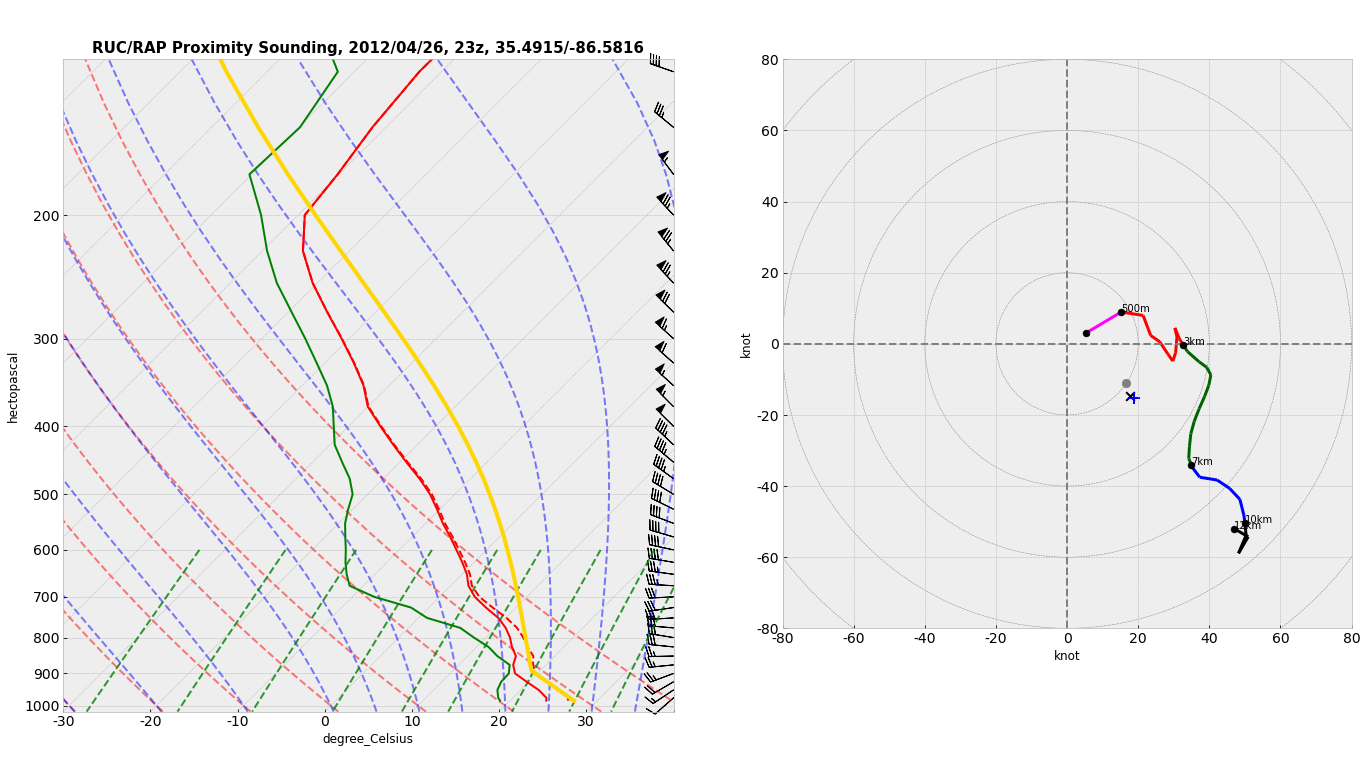

In [13]:
#%matplotlib inline

try:
    plt.style.use('bmh')
    #plt.title('21 UTC NARR Sounding 31 May 1985 Wheatland, PA')

    ## Change default to be better for skew-T
    fig = plt.figure(figsize=(24, 12))
    #skew = SkewT(fig)
    gs = gridspec.GridSpec(8, 4)
    skew = SkewT(fig, rotation=45, subplot=gs[:, :2])
    skew.plot(p_skewt, T_skewt, 'r')
    skew.plot(p_skewt, vtemp_pr[::-1], 'r', linestyle='--')
    skew.plot(p_skewt, Td_skewt, 'g')

    botwind = len(p_skewt)-1
    skew.plot_barbs(p_skewt[1:botwind], u_skewt[1:botwind], v_skewt[1:botwind])

    #profile1 = metcalc.parcel_profile(p_skewt[::-1], T_skewt[::-1], Td_skewt[::-1]).to('degC')
    #Plot the most unstable parcel path
    #skew.plot(pres_mu, mu_profile, 'orange', linewidth=4, linestyle = '--')
    #Plot the parcel path
    skew.plot(pprofile1, profile1, 'gold', linewidth=4)

    #Let's try to fill between the profile and parcel path.
    #greater = Tc >= prof
    #skew.ax.fill_betweenx(levc, Tc, prof, where=greater, facecolor='blue', alpha=0.4)
    #skew.ax.fill_betweenx(levc, Tc, prof, where=~greater, facecolor='red', alpha=0.4)

    skew.ax.set_ylim(1020, 120)
    ## Good bounds for aspect ratio
    skew.ax.set_xlim(-30, 40)
    skew.ax.set_xticklabels([-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30], size = 14)
    skew.ax.set_yticklabels([100,200,300,400,500,600,700,800,900,1000],size = 14)

    ## Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()

    sndtitle = "RUC/RAP Proximity Sounding, "+str(year)+"/"+str(month)+"/"+str(day)+", "+str(hour)+"z, "+str(cenlat)+"/"+str(cenlon)
    plt.title(sndtitle, fontsize=15, fontweight='bold')

    ax1 = fig.add_subplot(gs[:7, 2:])
    h = Hodograph(ax1,component_range=80.)
    h.add_grid(increment=20)

    skipwwind = 0
    for i in range(len(hgt_skewt)):    
        if hgt_skewt[i].magnitude > 12000:
            skipwind = i-1
    #print(skipwind)

    a = hgt_skewt[botwind].magnitude
    botarray = [500+a, 3000+a, 7000+a, 10000+a, 12000+a]
    
    #c = h.plot_colormapped(u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1]-hgt_skewt[-1], linewidth = 3, colors=None)    
    c = h.plot_colormapped(u_skewt[skipwind:botwind], v_skewt[skipwind:botwind], hgt_skewt[skipwind:botwind], 
                           intervals = botarray * units('meter'),
                           colors = ['red', 'darkgreen', 'blue', 'black'], linewidth = 3)

    ## Interpolate the wind levels
    hgt_points = metinterp([0, 500, 3000, 7000, 10000, 12000]*units('meter'),hgt_skewt[::-1]-hgt_skewt[-1], u_skewt[::-1], v_skewt[::-1])

    ## MetPy supercell motion
    h.ax.scatter(storm_motion[0][0].to('knots'), storm_motion[0][1].to('knots'), s = 75, color = 'gray')
    ## SHARPpy supercell motion
    h.ax.scatter(srwind[0], srwind[1], s = 75, color = 'black', marker ='x')
    ## B2K supercell motion
    h.ax.scatter(RMu/.5144, RMv/.5144, s = 155, color = 'blue', marker='+')

    uwndsfcBL = [hgt_points[0][0].magnitude, hgt_points[0][1].magnitude]
    vwndsfcBL = [hgt_points[1][0].magnitude, hgt_points[1][1].magnitude]
    plt.plot(uwndsfcBL, vwndsfcBL, color='magenta', linewidth = 3)

    h.ax.scatter(hgt_points[0][0], hgt_points[1][0], s = 48, color = 'black', zorder=10)
    h.ax.scatter(hgt_points[0][1], hgt_points[1][1], s = 48, color = 'black', zorder=10)
    h.ax.scatter(hgt_points[0][2], hgt_points[1][2], s = 48, color = 'black', zorder=10)
    h.ax.scatter(hgt_points[0][3], hgt_points[1][3], s = 48, color = 'black', zorder=10)
    h.ax.scatter(hgt_points[0][4], hgt_points[1][4], s = 48, color = 'black', zorder=10)
    h.ax.scatter(hgt_points[0][5], hgt_points[1][5], s = 48, color = 'black', zorder=10)
    plt.text(hgt_points[0][1], hgt_points[1][1], '500m', zorder=10)
    plt.text(hgt_points[0][2], hgt_points[1][2], '3km', zorder=10)
    plt.text(hgt_points[0][3], hgt_points[1][3], '7km', zorder=10)
    plt.text(hgt_points[0][4], hgt_points[1][4], '10km', zorder=10)
    plt.text(hgt_points[0][5], hgt_points[1][5], '12km', zorder=10)

    #cb = plt.colorbar(cl, shrink = .8)
    #cb.ax.set_yticklabels(['sfc','1,000','3,000','5,000','10,000'])
    #cb.set_label('Height AGL (m)')
    h.ax.set_xticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)
    h.ax.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)

    soundingname = "Soundings/sounding"+str(site)+"-"+str(year)+str(month)+str(day)+"-"+str(hour)+"z"
    if runSCM == 1:
        plt.savefig(soundingname, dpi=300, bbox_inches='tight')
    plt.show()
except:
    print()
    print("There is no RUC or RAP sounding availble. Try again later.")
    print() 

## Establish settings for the radar tracking algorithm
You can try setting the reflectivity thresholds the tracking algorithm uses (Reflev and Reflev1) up or down by a few dB so that the algorithm isn't trying to find multiple storms inside that one storm, You can also change the size threshold the algorithm uses to determine whether to consider splitting up a storm to a really big value so it doesn't split the storm (big_storm defaults to 300 sq. km., but setting it to something like 10,000 sq. km should fix this). Setting big_storm to a bigger value is probably the easier option.

Right now the tracking algorithm uses a 10-scan window to calculate the observed storm motion, but that can be tuned in the code so we can adjust that to see what settings might work best.

In [14]:
## Lower and upper relectivity thresholds used for the tracking algorithm
## For the rest
##REFlevs = np.asarray([45, 40])
##REFlev1s = np.asarray([50, 45])

## Size above which a storm is inspected for embedded areas of higher reflectivity above REFlevs1
## For the rest 
##big_storms = np.asarray([300, 300])


################################################################################

## These two parameters are obsolete and set to dummy values here
zero_z_triggers = np.asarray([25, 35])
storm_to_tracks = np.asarray([2, 2])

## Setting the start time for the case
years = np.asarray([int(yearR)])
months = np.asarray([int(monthR)])
days = np.asarray([int(dayR)])
hours = np.asarray([int(hourR)])

## Change to zero if duration = 1; otherwise set to 30 if duration = 2
#if duration == 2:
#  start_mins = np.asarray([minS])
#else:
#  start_mins = np.asarray([0])

## Case duration from the start time
start_mins = np.asarray([minS])
durations = np.asarray([float(duration)])

## Radar station
stations = [site]

## Information for ZDR calibration--not needed in this script, but kept since it's difficult to remove from the algorithm
h_calstm = np.asarray([3695, 3695])
calibrations = np.asarray([0.0, 0.0])

## Predicted Bunkers et al. (2014) storm speed, in m/s
predicted_speed = np.asarray([float(RMspd)])

## Predicted Bunkers et al. (2014) storm direction, in degrees
predicted_direction = np.asarray([float(RMdir)])

## Mean Wind Speeds in m/s
meanw_speed = np.asarray([MWspd.magnitude])

##Mean wind direction
meanw_dir = np.asarray([MWdir.magnitude])

##Bulk shear direction
shear_dir = np.asarray([BSHRdir.magnitude])
shear_dir3km = np.asarray([BSHRdir3km.magnitude])
shear_dir1km = np.asarray([BSHRdir1km.magnitude])

if offhodoshear == 3:
    shear_dir = shear_dir3km
if offhodoshear == 1:
    shear_dir = shear_dir1km

print()
print(years,months,days,hours,start_mins,durations,stations,predicted_speed,predicted_direction)
print()
print(meanw_speed, meanw_dir, shear_dir, predicted_direction, predicted_speed)
print()

print()
print(meanw_speed, meanw_dir, shear_dir, predicted_direction, predicted_speed)
print()


## For 29 May 2008 KUEX case study

#meanw_speed[0] = 16.86
#meanw_dir[0] = 220.0
#shear_dir[0] = 282.0
#predicted_direction[0] = 240.5
#predicted_speed[0] = 11.06

#print()
#print(meanw_speed, meanw_dir, shear_dir, predicted_direction, predicted_speed)
#print()


## For 28 May 2013 KTWX case study

#meanw_speed[0] = 16.33
#meanw_dir[0] = 222.0
#shear_dir[0] = 258.0
#predicted_direction[0] = 249.0
#predicted_speed[0] = 13.25

#print()
#print(meanw_speed, meanw_dir, shear_dir, predicted_direction, predicted_speed)
#print()



[2012] [4] [26] [22] [25] [1.9] ['KOHX'] [12.53] [309.07]

[15.8028234] [281.31389764] [320.24146093] [309.07] [12.53]


[15.8028234] [281.31389764] [320.24146093] [309.07] [12.53]



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Loop to run the storm motion deltas algorithm; this can take 10-15 minutes.

In [205]:
print()
print(datetime.utcnow())
print()

#for i in range(len(durations)):
for i in [0]:
    if isDir == True and runSCM == 1 and forceRADAR == 0:
        tracks_dataframe = storm_motion_deltas_local(REFlevs[i],REFlev1s[i],big_storms[i],numsecs,70,storm_to_tracks[i],years[i],months[i],days[i],hours[i],start_mins[i],durations[i],calibrations[i],offhodoshear,stations[i], localradar, predicted_speed[i], predicted_direction[i], meanw_speed[i], meanw_dir[i], shear_dir[i], track_dis=searchkm, GR_mins = 1.0)
        tracks_dataframe.to_pickle('Pickles/ARCDEV'+str(years[i])+str(months[i])+str(days[i])+str(hours[i])+str(stations[i])+str(numsecs)+"sec"+str(offhodoshear)+"km.pkl")
    elif runSCM == 1:
        tracks_dataframe = storm_motion_deltas_algorithm(REFlevs[i],REFlev1s[i],big_storms[i],numsecs,70,storm_to_tracks[i],years[i],months[i],days[i],hours[i],start_mins[i],durations[i],calibrations[i],offhodoshear,stations[i], predicted_speed[i], predicted_direction[i], meanw_speed[i], meanw_dir[i], shear_dir[i], track_dis=searchkm, GR_mins = 1.0)
        tracks_dataframe.to_pickle('Pickles/ARCDEV'+str(years[i])+str(months[i])+str(days[i])+str(hours[i])+str(stations[i])+str(numsecs)+"sec"+str(offhodoshear)+"km.pkl")
        if not os.path.exists(newpath):
            os.makedirs(newpath)
            print(newpath)
        for data in glob.glob("RadarFolder/*.gz"):
            try:
                shutil.move(data,newpath)
            except:
                shutil.copy(data,newpath)
        for data in glob.glob("RadarFolder/*V06"):
            try:
                shutil.move(data,newpath)
            except:
                shutil.copy(data,newpath)
        for data in glob.glob("RadarFolder/*MDM"):
            try:
                shutil.move(data,newpath)
            except:
                shutil.copy(data,newpath)
    if not os.path.exists(MLpath):
        os.makedirs(MLpath)
        print(MLpath)
    for data in glob.glob(MLfiles):
        #print(data)
        shutil.copy(data,MLpath)
    #tracks_dataframe, zdroutlines, col_areas, col_lon, col_storm_lon = multi_case_algorithm_ML1_devLOCAL(storm_relative_dirs[i],3.25,1.5,REFlevs[i],REFlev1s[i],big_storms[i],70,storm_to_tracks[i],years[i],months[i],days[i],hours[i],start_mins[i],durations[i],calibrations[i],stations[i],h_calstm[i], localfolder[i], track_dis=10)
    #Saving the output to a .pkl file
print()
print(datetime.utcnow())
print()



2021-08-04 22:05:34.648078


2021-08-04 22:05:34.651076



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Clean up remaining RadarFolder *.gz and Machine_Learning *.png files.

In [206]:
for f in os.listdir("RadarFolder"):
    pattern = 'gz'
    if re.search(pattern, f):
        print(os.path.join("RadarFolder", f))
        os.remove(os.path.join("RadarFolder", f))
        
for f in os.listdir("Machine_Learning"):
    pattern = 'png'
    if re.search(pattern, f):
        print(os.path.join("Machine_Learning", f))
        os.remove(os.path.join("Machine_Learning", f))

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Find the storm ID that has the most data.

In [207]:
var5 = 'storm_id1'
startstorm = 0
if stormID < 0:
    for storm in range(0, 50):
        try:
            picklename = "Pickles/ARCDEV"+str(yearR)+str(int(monthR))+str(int(dayR))+str(int(hourR))+site+str(numsecs)+"sec"+str(offhodoshear)+"km.pkl"
            CI_T_2 = pd.read_pickle(picklename)
            storm2 = CI_T_2.xs(storm, level = 1)
            storm2_alg_var5 = np.asarray(storm2[var5].iloc[:])
            numstorms = storm2_alg_var5.shape
            print(numstorms[0], "scans")
            print ("stormID = ", storm)        
            if numstorms[0] > startstorm:
                startstorm = numstorms[0]
                stormID = storm
                print ("new top stormID = ", storm, ";", startstorm, "scans")
            print()
        except:
            #print ("no storms")
            pi = 3.14
print("top stormID = ", stormID)

top stormID =  0


x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Set the "var" you're looking for and the stormID you need it from. The stormID is the number the storm is assigned in the plots from the algorithm output. This is set at the beginning of this script (default = 0) using the Inputdata.csv file, and should be updated after this script is run if the stormID is different from 0.

In [208]:
var0 = 'off-hodograph deviation'
var1 = 'motion_deltas'
var2 = 'storm speed'
var3 = 'storm direction'
var4 = 'times'

## Manually override stormID, if needed
#stormID = 27
storm = stormID

picklename = "Pickles/ARCDEV"+str(yearR)+str(int(monthR))+str(int(dayR))+str(int(hourR))+site+str(numsecs)+"sec"+str(offhodoshear)+"km.pkl"
print()
print("stormID =", storm, "; filename =", picklename)
print()

## Specify name of the pickle file and read in initial data
CI_T_2 = pd.read_pickle(picklename)
storm2 = CI_T_2.xs(storm, level = 1)
storm2_times_var = np.asarray(storm2['times'].iloc[:])
storm2_alg_var0 = np.asarray(storm2[var0].iloc[:])
storm2_alg_var1 = np.asarray(storm2[var1].iloc[:])
storm2_alg_var2 = np.asarray(storm2[var2].iloc[:])
storm2_alg_var3 = np.asarray(storm2[var3].iloc[:])
storm2_alg_var4 = np.asarray(storm2[var4].iloc[:])

slat2=np.asarray(storm2['storm_lat'].iloc[:])[:]
slon2=np.asarray(storm2['storm_lon'].iloc[:])[:]

## Set missing values to nan
try:
    storm2_alg_var1[storm2_alg_var1==0] = np.nan
except:
    print('oops')


stormID = 0 ; filename = Pickles/ARCDEV201352821KTWX1200sec6km.pkl



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## This block prints out all of the values for the variable you input below.

In [209]:
print(storm2_alg_var0.shape)
print()
print(var0)
print(storm2_alg_var0)
print(var2)
print(storm2_alg_var2)
print(var3)
print(storm2_alg_var3)
print(var4)
print(storm2_alg_var4)
print()

(26,)

off-hodograph deviation
[        nan         nan         nan         nan         nan  9.65063116
 10.08749163 10.06019548 10.02575109  9.82331249  9.57348006  9.07933696
  9.05488345  8.95583233  7.96688117  7.68702069  8.31062935  8.92966885
  9.39792233  9.66060485  9.31514044  9.20654241  9.53645315  9.74471908
  9.0863971   9.10003787]
storm speed
[0.         0.         0.         0.         0.         0.18136918
 2.92079722 4.13349209 5.23380703 4.25420006 3.31708205 2.65226563
 1.97857332 1.737806   4.14465115 7.12849474 6.64096755 4.59493235
 2.91704487 0.66813638 1.39318927 2.74376448 1.38705181 0.59299382
 0.91898775 0.75315344]
storm direction
[  0.           0.           0.           0.           0.
 274.69328629 267.63702227 264.4126423  262.68206935 261.02874948
 257.5672549  246.71112507 242.05177839 236.29458094 234.81654009
 242.44573416 246.81759152 249.62996388 254.05654532 263.33062026
  89.73660998  86.21372568  80.5652336   63.72821442 111.86809345
 119.4432

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## This block prints the first 5 times associated with that storm object

In [210]:
print()
print(storm2_times_var[0:4])
print(storm2_times_var.shape)
print()

xlabels = ["" for i in range(len(storm2_times_var))]
xvalues = [0] * len(storm2_times_var)
for i in range(len(storm2_times_var)):
    if int(storm2_times_var[i].hour) > 9:
        if int(storm2_times_var[i].minute) > 9:
            xlabels[i] = str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute)+"z"
            xvalues[i] = int(str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute))
        else:
            xlabels[i] = str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute)+"z"
            xvalues[i] = int(str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute))
    else:
        if int(storm2_times_var[i].minute) > 9:
            xlabels[i] = "0"+str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute)+"z"
            xvalues[i] = int(str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute))
        else:
            xlabels[i] = "0"+str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute)+"z"
            xvalues[i] = int(str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute))
#print(xlabels)
print(xvalues)
print()

#print(storm2_times_var[0])
#print(storm2_times_var[0].year)
#print(storm2_times_var[0].month)
#print(storm2_times_var[0].day)
#print(storm2_times_var[0].hour)
#print(storm2_times_var[5].minute)
#print(storm2_times_var[0].second)


[cftime.DatetimeGregorian(2013, 5, 28, 21, 28, 2, 583000)
 cftime.DatetimeGregorian(2013, 5, 28, 21, 32, 20, 722000)
 cftime.DatetimeGregorian(2013, 5, 28, 21, 36, 39, 159000)
 cftime.DatetimeGregorian(2013, 5, 28, 21, 40, 57, 391000)]
(26,)

[2128, 2132, 2136, 2140, 2145, 2149, 2153, 2158, 2202, 2206, 2211, 2215, 2219, 2223, 2228, 2232, 2236, 2241, 2245, 2249, 2254, 2258, 2302, 2306, 2311, 2315]



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## This block prints out part of the pandas dataframe with all of the variables and values. Avaliable variables are storm speed (m/s), storm direction (deg), motion_deltas (m/s), storm_lon, storm_lat, and the time of each scan.

In [211]:
#print(CI_T_2)
print()
print(CI_T_2[0:5])
print()


               storm speed  storm direction  motion_deltas  \
scan storm_id                                                
0    0                 0.0              0.0            NaN   
     1                 0.0              0.0            NaN   
     2                 0.0              0.0            NaN   
1    0                 0.0              0.0            NaN   
     2                 0.0              0.0            NaN   

               off-hodograph deviation  storm_id1  storm_lon  storm_lat  \
scan storm_id                                                             
0    0                             NaN          0 -95.933778  39.762717   
     1                             NaN          1 -95.728958  40.339068   
     2                             NaN          2 -95.532799  40.449204   
1    0                             NaN          0 -95.936088  39.765173   
     2                             NaN          2 -95.493709  40.466849   

                                    ti

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Plot the storm deltas and off-hodograph deviations over the volume scan times for the storm.  Observed EF-scale ratings are plotted as size-weighted and color-specific circles.

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


yes
Tornado-data/Tordata-KTWX-2013-5-28_1.csv
[2233 2245 2246 2247 2248 2249 2250 2251 2252 2253 2254 2255 2256 2257
 2258 2259 2300 2301 2302 2303 2304 2305 2306 2307 2308 2309 2310 2311
 2312 2313 2314 2315 2316 2317 2318 2319 2320 2321 2322 2323 2324 2325
 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2337 2338 2339
 2340 2341 2342 2343 2344]
[0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[2128, 2132, 2136, 2140, 2145, 2149, 2153, 2158, 2202, 2206, 2211, 2215, 2219, 2223, 2228, 2232, 2236, 2241, 2245, 2249, 2254, 2258, 2302, 2306, 2311, 2315]
1 2233
4 2245
0 2245
1 2246
2 2247
3 2248
4 2249
0 2249
1 2250
2 2251
3 2252
4 2253
5 2254
0 2254
1 2255
2 2256
3 2257
4 2258
0 2258
1 2259
42 2300
43 2301
44 2302
0 2302
1 2303
2 2304
3 2305
4 2306
0 2306
1 2307
2 2308
3 2309
4 2310
5 2311
0 2311
1 2312
2 2313
3 2314
4 2315


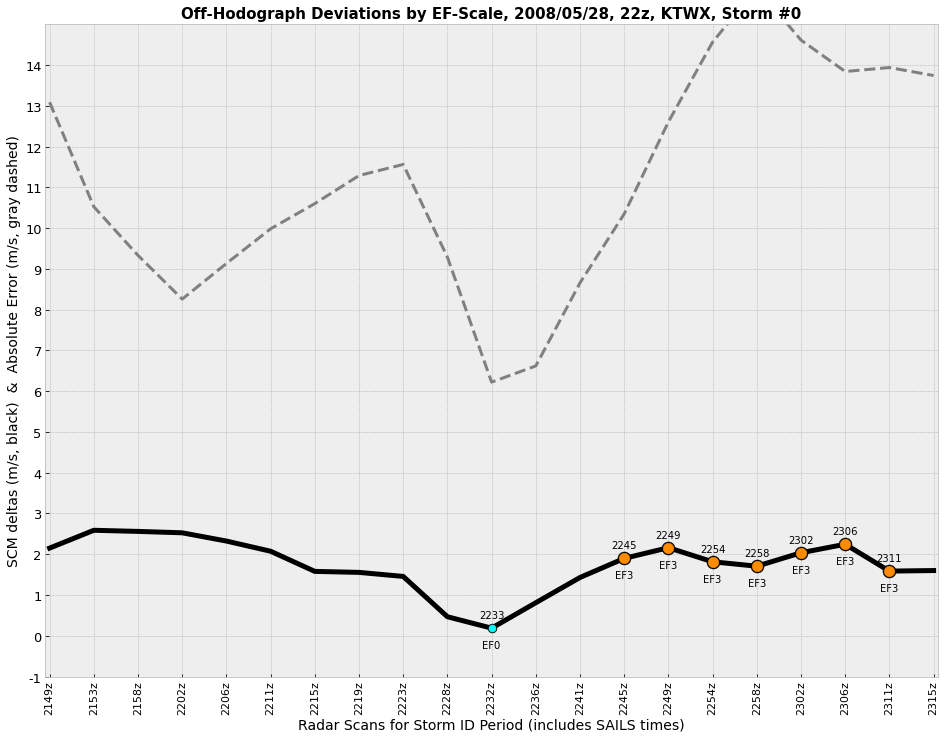

In [212]:
try:
    plt.figure(1, figsize=(16, 12))

    for i in range(len(storm2_alg_var0)-1):
        if storm2_times_var[i].hour < int(hour) and storm2_times_var[i+1].hour == int(hour):
            #print(i)
            startindex = i
        elif storm2_times_var[i].hour == int(hour) and storm2_times_var[i+1].hour > int(hour):
            #print(i)
            stopindex = i + 1 

    #xr = np.arange(0, storm2_alg_var0.shape[0], 1)
    startindex = 0
    stopindex = storm2_alg_var0.shape[0]

    xr = np.arange(startindex, stopindex, 1)

    plt.plot(xr, storm2_alg_var0[startindex:stopindex]-7.5, linewidth=5, color='black')
    plt.plot(xr, storm2_alg_var1[startindex:stopindex], linewidth=3, color='gray', linestyle='dashed')
    plt.xticks(xr, xlabels[startindex:stopindex], rotation='vertical', fontsize=11)

    #print(xlabels[0])

    try:
        filename = "Tornado-data/Tordata-"+site+"-"+str(yearR)+"-"+str(monthR)+"-"+str(dayC)+"_"+str(stormNum)+".csv"
        Tordata = np.genfromtxt(filename, delimiter = ",", skip_header = 1, dtype=int)
        print("yes")
    except:
        filename = "Tornado-data/No-tornadoes.csv"
        Tordata = np.genfromtxt(filename, delimiter = ",", skip_header = 1, dtype=int)
        print("no")
    print(filename)    

    tortimes = Tordata[:,0]
    torEFscales = Tordata[:,1]
    print(tortimes)
    print(torEFscales)
    #print(len(tortimes))
    #print(len(torEFscales))
    print(xvalues)

    #for i in range(len(xvalues)-1):
    for i in range(startindex, stopindex-1):
        nolabel = 0    
        for j in range(len(tortimes)):
            #if tortimes[j] >= xvalues[i] and tortimes[j] <= xvalues[i+1] and xvalues[i] >= tortimes[j]:
            if xvalues[i] < xvalues[i+1] or (xvalues[i] > 2300 and xvalues[i+1] < 60):
                if (xvalues[i] <= tortimes[j] and tortimes[j] <= xvalues[i+1]) or ((xvalues[i] > xvalues[i+1]) and (xvalues[i] > tortimes[j] and tortimes[j] <= xvalues[i+1])):
                    delta1 = abs(xvalues[i] - tortimes[j])
                    if xvalues[i] > xvalues[i+1]:
                        delta1 = abs(xvalues[i] - (tortimes[j]+2360))
                    print(delta1, tortimes[j])
                    if torEFscales[j] == 0 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=80, c='black', zorder=5)                
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=50, c='cyan', zorder=5)  
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF0', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 1 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=110, c='black', zorder=6)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=70, c='lawngreen', zorder=6)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF1', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 2 and delta1 < 4 and nolabel == 0:                
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=140, c='black', zorder=7)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=90, c='yellow', zorder=7)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF2', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 3 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=170, c='black', zorder=8)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=110, c='darkorange', zorder=8)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF3', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 4 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=200, c='black', zorder=9)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=130, c='red', zorder=9)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF4', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 5 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=230, c='black', zorder=10)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=150, c='magenta', zorder=10)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF5', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == -1 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=60, c='black', zorder=4)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=40, c='white', zorder=4)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EFU', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 9 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        #plt.scatter(xr[i-startindex], storm2_alg_var0[i]-7.5, s=140, marker='X', c='black', zorder=4)                
                        #plt.scatter(xr[i-startindex], storm2_alg_var0[i]-7.5, s=140, marker=r"$ {} $".format("F"), c='lawngreen', zorder=4)                
                        plt.annotate("F", (xr[i],storm2_alg_var0[i]-7.5), c='black', size=26)
                        plt.annotate("F", (xr[i],storm2_alg_var0[i]-7.5), c='cyan', size=23)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
            else:
                if xvalues[i] >= tortimes[j] and tortimes[j] <= xvalues[i+1]:
                    delta1 = abs(xvalues[i] - tortimes[j])                
                    if torEFscales[j] == 0 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=80, c='black', zorder=5)                
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=50, c='cyan', zorder=5)  
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF0', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 1 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=110, c='black', zorder=6)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=70, c='lawngreen', zorder=6)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF1', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 2 and delta1 < 4 and nolabel == 0:                
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=140, c='black', zorder=7)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=90, c='yellow', zorder=7)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF2', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 3 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=170, c='black', zorder=8)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=110, c='darkorange', zorder=8)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF3', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 4 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=200, c='black', zorder=9)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=130, c='red', zorder=9)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF4', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 5 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=230, c='black', zorder=10)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=150, c='magenta', zorder=10)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EF5', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == -1 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=60, c='black', zorder=4)
                        plt.scatter(xr[i], storm2_alg_var0[i]-7.5, s=40, c='white', zorder=4)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')
                        plt.annotate('EFU', (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,-20), ha='center', color='black')
                    elif torEFscales[j] == 9 and delta1 < 4 and nolabel == 0:
                        nolabel = 1
                        #plt.scatter(xr[i-startindex], storm2_alg_var0[i]-7.5, s=140, marker='X', c='black', zorder=4)                
                        #plt.scatter(xr[i-startindex], storm2_alg_var0[i]-7.5, s=140, marker=r"$ {} $".format("F"), c='lawngreen', zorder=4)                
                        plt.annotate("F", (xr[i],storm2_alg_var0[i]-7.5), c='black', size=26)
                        plt.annotate("F", (xr[i],storm2_alg_var0[i]-7.5), c='cyan', size=23)
                        plt.annotate(tortimes[j], (xr[i], storm2_alg_var0[i]-7.5), textcoords='offset points', 
                                     xytext=(0,10), ha='center')

    ## Use these for a variable y axis based on the data
    ymax = int(np.nanmax(storm2_alg_var1[startindex:stopindex]))+1
    ymin = int(np.nanmin(storm2_alg_var0[startindex:stopindex]-7.5))-1

    ## Use these if you want a fixed y axis; otherwise, comment these out
    #ymax = 10
    #ymin = -4
    if ymax > 15:
        ymax = 15
    if ymin < -15:
        ymin = -10
    plt.ylim(ymin, ymax)

    yr = np.arange(ymin, ymax, 1)

    plt.yticks(yr, yr, fontsize=13)
    plt.margins(0.005, 0.05)

    plt.xlabel("Radar Scans for Storm ID Period (includes SAILS times)", fontsize=14)
    #plt.ylabel("Storm Motion Deltas (m/s)")
    #plt.ylabel(var0+" - 7.5 m/s (black)  &  "+var1+" (m/s, gray dashed)", fontsize=14)
    plt.ylabel("SCM deltas (m/s, black)  &  Absolute Error (m/s, gray dashed)", fontsize=14)

    scattertitle = "Off-Hodograph Deviations by EF-Scale, "+str(year)+"/"+str(month)+"/"+str(day)+", "+str(hour)+"z, "+str(site)+", Storm #"+str(stormID)
    plt.title(scattertitle, fontsize=15, fontweight='bold')

    scattername = "Scatterplots/scatter"+str(site)+str(stormNum)+"-"+str(year)+str(month)+str(day)+"-"+str(hour)+"z-storm"+str(stormID)+'_'+str(searchkm)+'km_'+str(numsecs)+'secs_0-'+str(offhodoshear)+'km_'+str(REFlevs[0])+'dBZ_'+str(REFlev1s[0])+'dBZ'
    plt.savefig(scattername, dpi=300, bbox_inches='tight')

    plt.plot
except:
    print("Unable to process the storm!")

## Repeat the scatter plot steps for a second storm.

In [213]:
if stormID2 > -1:
    var0 = 'off-hodograph deviation'
    var1 = 'motion_deltas'
    var2 = 'storm speed'
    var3 = 'storm direction'
    var4 = 'times'
    storm = stormID2

    picklename = "Pickles/ARCDEV"+str(yearR)+str(int(monthR))+str(int(dayR))+str(int(hourR))+site+str(numsecs)+"sec"+str(offhodoshear)+"km.pkl"
    print()
    print("stormID2 =", storm, "; filename =", picklename)
    print()

    ## Specify name of the pickle file and read in initial data
    CI_T_2 = pd.read_pickle(picklename)
    storm2 = CI_T_2.xs(storm, level = 1)
    storm2_times_var = np.asarray(storm2['times'].iloc[:])
    storm2_alg_var0 = np.asarray(storm2[var0].iloc[:])
    storm2_alg_var1 = np.asarray(storm2[var1].iloc[:])
    storm2_alg_var2 = np.asarray(storm2[var2].iloc[:])
    storm2_alg_var3 = np.asarray(storm2[var3].iloc[:])
    storm2_alg_var4 = np.asarray(storm2[var4].iloc[:])

    slat2=np.asarray(storm2['storm_lat'].iloc[:])[:]
    slon2=np.asarray(storm2['storm_lon'].iloc[:])[:]

    ## Set missing values to nan
    try:
        storm2_alg_var1[storm2_alg_var1==0] = np.nan
    except:
        print('oops')
else:
    print("...")


stormID2 = 16 ; filename = Pickles/ARCDEV201352821KTWX1200sec6km.pkl



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [214]:
if stormID2 > -1:
    xlabels = ["" for i in range(len(storm2_times_var))]
    xvalues = [0] * len(storm2_times_var)
    for i in range(len(storm2_times_var)):
        if int(storm2_times_var[i].hour) > 9:
            if int(storm2_times_var[i].minute) > 9:
                xlabels[i] = str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute)+"z"
                xvalues[i] = int(str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute))
            else:
                xlabels[i] = str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute)+"z"
                xvalues[i] = int(str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute))
        else:
            if int(storm2_times_var[i].minute) > 9:
                xlabels[i] = "0"+str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute)+"z"
                xvalues[i] = int(str(storm2_times_var[i].hour)+str(storm2_times_var[i].minute))
            else:
                xlabels[i] = "0"+str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute)+"z"
                xvalues[i] = int(str(storm2_times_var[i].hour)+"0"+str(storm2_times_var[i].minute))
    print(xvalues, xlabels)
    print()
else:
    print("...")

[2236, 2241, 2245, 2249, 2254, 2258, 2302, 2306, 2311, 2315] ['2236z', '2241z', '2245z', '2249z', '2254z', '2258z', '2302z', '2306z', '2311z', '2315z']



x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


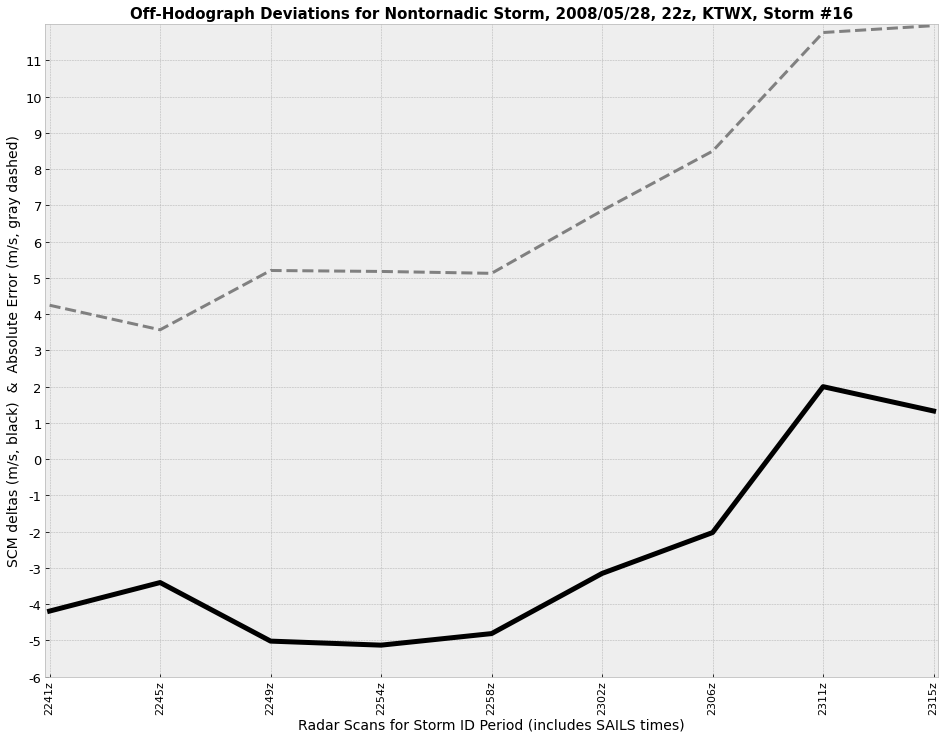

In [215]:
try:
    if stormID2 > -1:
        plt.figure(1, figsize=(16, 12))
    
        for i in range(len(storm2_alg_var0)-1):
            if storm2_times_var[i].hour < int(hour) and storm2_times_var[i+1].hour == int(hour):
                #print(i)
                startindex = i
            elif storm2_times_var[i].hour == int(hour) and storm2_times_var[i+1].hour > int(hour):
                #print(i)
                stopindex = i + 1 
    
        #xr = np.arange(0, storm2_alg_var0.shape[0], 1)
        startindex = 0
        stopindex = storm2_alg_var0.shape[0]
    
        xr = np.arange(startindex, stopindex, 1)
    
        #plt.plot(xr, storm2_alg_var0[startindex:stopindex]-7.5, linewidth=5, color='black')
        #plt.plot(xr, storm2_alg_var1[startindex:stopindex], linewidth=3, color='gray', linestyle='dashed')
        #plt.xticks(xr, xlabels[startindex:stopindex], rotation='vertical', fontsize=11)
        
        #print(xr, storm2_alg_var0[startindex:stopindex])
        s1mask = np.isfinite(storm2_alg_var0[startindex:stopindex])
        #print(s1mask)
        s2mask = np.isfinite(storm2_alg_var1[startindex:stopindex])
        #print(s1mask, s2mask)
        plt.plot(xr[s1mask], storm2_alg_var0[s1mask]-7.5, linewidth=5, color='black')
        plt.plot(xr[s2mask], storm2_alg_var1[s2mask], linewidth=3, color='gray', linestyle='dashed')
        plt.xticks(xr, xlabels[startindex:stopindex], rotation='vertical', fontsize=11)
    
        #print(xlabels[0])
    
        ## Use these for a variable y axis based on the data
        ymax = int(np.nanmax(storm2_alg_var1[startindex:stopindex]))+1
        ymin = int(np.nanmin(storm2_alg_var0[startindex:stopindex]-7.5))-1
    
        ## Use these if you want a fixed y axis; otherwise, comment these out
        #ymax = 10
        #ymin = -4
        if ymax > 15:
            ymax = 15
        if ymin < -15:
            ymin = -10
        plt.ylim(ymin, ymax)
    
        yr = np.arange(ymin, ymax, 1)
    
        plt.yticks(yr, yr, fontsize=13)
        plt.margins(0.005, 0.05)
    
        plt.xlabel("Radar Scans for Storm ID Period (includes SAILS times)", fontsize=14)
        #plt.ylabel("Storm Motion Deltas (m/s)")
        #plt.ylabel(var0+" - 7.5 m/s (black)  &  "+var1+" (m/s, gray dashed)", fontsize=14)
        plt.ylabel("SCM deltas (m/s, black)  &  Absolute Error (m/s, gray dashed)", fontsize=14)
    
        scattertitle = "Off-Hodograph Deviations for Nontornadic Storm, "+str(year)+"/"+str(month)+"/"+str(day)+", "+str(hour)+"z, "+str(site)+", Storm #"+str(stormID2)
        plt.title(scattertitle, fontsize=15, fontweight='bold')
    
        scattername = "Scatterplots/scatter"+str(site)+str(stormNum)+"-"+str(year)+str(month)+str(day)+"-"+str(hour)+"z-storm"+str(stormID2)+'_'+str(searchkm)+'km_'+str(numsecs)+'secs_0-'+str(offhodoshear)+'km_'+str(REFlevs[0])+'dBZ_'+str(REFlev1s[0])+'dBZ'
        plt.savefig(scattername, dpi=300, bbox_inches='tight')
    
        plt.plot
    else:
        print("We are all done!")
except:
    print("Unable to process the storm!")

## Clean up remaining Scatterplot *.png files.

In [216]:
if not os.path.exists(scatterpath):
    os.makedirs(scatterpath)
    print(scatterpath)

x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [217]:
if not os.path.exists(scatterpath):
    os.makedirs(scatterpath)
    print(scatterpath)

for data in glob.glob(scatterfiles):
    print(data)
    print()
    shutil.copy(data,scatterpath)

for f in os.listdir("Scatterplots"):
    pattern = 'png'
    if re.search(pattern, f):
        print(os.path.join("Scatterplots", f))
        os.remove(os.path.join("Scatterplots", f))

Scatterplots\scatterKTWX1-20080528-22z-storm0_10km_1200secs_0-6km_45dBZ_50dBZ.png

Scatterplots\scatterKTWX1-20080528-22z-storm16_10km_1200secs_0-6km_45dBZ_50dBZ.png

Scatterplots\scatterKTWX1-20080528-22z-storm0_10km_1200secs_0-6km_45dBZ_50dBZ.png
Scatterplots\scatterKTWX1-20080528-22z-storm16_10km_1200secs_0-6km_45dBZ_50dBZ.png


x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
pklstr = "Pickles/ARCDEV"+str(yearR)+str(monthR)+str(dayR)+str(hourR)+str(site)+str(numsecs)+"sec"+str(offhodoshear)+"km.pkl"
print(pklstr)
with open(pklstr, 'rb') as f:
    statistics_array = pickle.load(f)
#statistics_array[["storm_id1", "motion_deltas", "off-hodograph deviation", "times"]].to_csv('Test_PKL.csv')
statistics_array["times"]
#statistics_array[statistics_array["storm_id1"] == stormID]
#statistics_array[statistics_array["storm_id1"] == stormID2]
#statistics_array[4:70]
#statistics_array.info()

Pickles/ARCDEV201352821KTWX1200sec6km.pkl


x:\anaconda\envs\scmdeltas\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scan  storm_id
0     0           2013-05-28 21:28:02.583000
      1           2013-05-28 21:28:02.583000
      2           2013-05-28 21:28:02.583000
1     0           2013-05-28 21:32:20.722000
      2           2013-05-28 21:32:20.722000
                             ...            
25    22          2013-05-28 23:15:31.543000
      0           2013-05-28 23:15:31.543000
      20          2013-05-28 23:15:31.543000
      26          2013-05-28 23:15:31.543000
      24          2013-05-28 23:15:31.543000
Name: times, Length: 135, dtype: object